In [ ]:
!pip install shap==0.39.0

     |████████████████████████████████| 356 kB 15.0 MB/s 
     |████████████████████████████████| 3.4 MB 35.9 MB/s 
     |████████████████████████████████| 25.3 MB 39.7 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=416307 sha256=d11f57807654739ac97bde93b8fefd6f73bcf619f65d8514af8b722f7af29404
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [ ]:
!pip install statsmodels==0.12.2

     |████████████████████████████████| 9.5 MB 27.9 MB/s 
     |████████████████████████████████| 231 kB 41.6 MB/s 


In [ ]:
# Start writing code here...
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from sklearn.preprocessing import OneHotEncoder
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
import seaborn as sns
import shap
import statsmodels.api as sm
from statsmodels import graphics
import scipy
import pylab

In [ ]:
def calculate_age(birthDate):
    #birthDate=str(birthDate)
    d,m,y = birthDate.split('-')
    if int(y) < 21: y='20'+y
    else: y= '19'+y
    b = date(int(y),int(m),int(d))
    today=date.today()
    return today.year - b.year - ((today.month, today.day) <(b.month, b.day))

def yrs_mon_to_month(s):
    sp=re.split('yrs|mon',s)
    return int(sp[0])*12 + int(sp[1])

def encode_description(X):
    '''

    '''
    X=X.drop('PERFORM_CNS.SCORE', axis=1) # drop PERFORM_CNS.SCORE
    X['PERFORM_CNS.SCORE.DESCRIPTION'] = X['PERFORM_CNS.SCORE.DESCRIPTION'].replace(('No Bureau History Available', 
                                     'Not Scored: Sufficient History Not Available','Not Scored: Not Enough Info available on the customer',
                                     'Not Scored: No Activity seen on the customer (Inactive)', 
                                     'Not Scored: No Updates available in last 36 months', 'Not Scored: Only a Guarantor'),(0, 0, 0, 0, 0, 0))

    X['PERFORM_CNS.SCORE.DESCRIPTION'] = X['PERFORM_CNS.SCORE.DESCRIPTION'].replace(('L-Very High Risk', 'M-Very High Risk', 
                                     'Not Scored: More than 50 active Accounts found'), (1, 1, 1))

    X['PERFORM_CNS.SCORE.DESCRIPTION'] = X['PERFORM_CNS.SCORE.DESCRIPTION'].replace(('J-High Risk', 'K-High Risk'), (2, 2))

    X['PERFORM_CNS.SCORE.DESCRIPTION'] = X['PERFORM_CNS.SCORE.DESCRIPTION'].replace(('H-Medium Risk', 'I-Medium Risk'), (3, 3))

    X['PERFORM_CNS.SCORE.DESCRIPTION'] = X['PERFORM_CNS.SCORE.DESCRIPTION'].replace(('E-Low Risk', 'F-Low Risk', 'G-Low Risk'), (4, 4, 4))

    X['PERFORM_CNS.SCORE.DESCRIPTION'] = X['PERFORM_CNS.SCORE.DESCRIPTION'].replace(('A-Very Low Risk', 'B-Very Low Risk',
                                      'C-Very Low Risk', 'D-Very Low Risk'), (5, 5, 5, 5))
    return X

def get_balance(df):
    # down sampling negative instances(nondefault), keep all the positive instances
    nondefault=df[df.loan_default==0].sample(n=df.loan_default.value_counts()[1], random_state=0)
    default=df[df.loan_default==1]
    df_balance= default.append(nondefault, ignore_index=True)
    df_balance=df_balance.sample(n=len(df_balance))
    return df_balance

In [ ]:
def preprocess(df):
    # transform birthDate to age
    df['Date.of.Birth']=df['Date.of.Birth'].apply(lambda x: calculate_age(x))
    df=df.rename(columns={'Date.of.Birth': 'Age'})

    # one hot encoding Employment.Type
    enc = OneHotEncoder(handle_unknown='ignore')
    enc_df=pd.DataFrame(enc.fit_transform(df[['Employment.Type']]).toarray())
    df=df.join(enc_df)
    df.columns = df.columns.astype(str) 
    df=df.rename(columns={'0': 'Salaried',
                       '1': 'Self_employed',
                       '2': 'Unknown_employ'})
    df=df.drop('Employment.Type',axis=1)

    # 
    df['AVERAGE.ACCT.AGE']=df['AVERAGE.ACCT.AGE'].apply(lambda s: yrs_mon_to_month(s))
    df['CREDIT.HISTORY.LENGTH']=df['CREDIT.HISTORY.LENGTH'].apply(lambda s: yrs_mon_to_month(s))

    # transform DisbursalDate to month
    df['DisbursalDate']=pd.to_datetime(df['DisbursalDate'],errors='coerce',dayfirst=True).dt.month
    df=df.rename(columns={'DisbursalDate': 'DisbursalMonth'})

    # encoding DisbursalMonth
    df=pd.get_dummies(df, columns=["DisbursalMonth"], prefix=["DisbursalMonth"])
    df['DisbursalMonth_8'] = df['DisbursalMonth_8'].astype(int)
    df['DisbursalMonth_9'] = df['DisbursalMonth_8'].astype(int)
    df['DisbursalMonth_10'] = df['DisbursalMonth_8'].astype(int)

    # encoding description
    df=encode_description(df)

    # drop some columns with ID (will try encoding later)
    id_col_to_drop=['UniqueID','branch_id','supplier_id', 'manufacturer_id', 'Current_pincode_ID','State_ID', 'Employee_code_ID']
    df=df.drop(columns=id_col_to_drop)

    # merge asset_cost and disbursed_amount
    df['Downpayment']=df['asset_cost']-df['disbursed_amount']
    df=df.drop(['asset_cost','disbursed_amount'],axis=1)

    drop_max=['PRI.NO.OF.ACCTS','PRI.SANCTIONED.AMOUNT','PRI.DISBURSED.AMOUNT','DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS']
    for d in drop_max:
        df= df.drop(index=df[df[d]== max(df[d])].index[0])

    drop_2max=['Downpayment','SEC.INSTAL.AMT']
    for d in drop_2max:
        df= df.drop(index=df[df[d]== max(df[d])].index[0])
        df= df.drop(index=df[df[d]== max(df[d])].index[0])

    # 'PRI.CURRENT.BALANCE', 'SEC.CURRENT.BALANCE' has negative values
    #print('Taking logrithmic')
    df['PRI.CURRENT.BALANCE']=df['PRI.CURRENT.BALANCE']-np.min(df['PRI.CURRENT.BALANCE'])
    df['SEC.CURRENT.BALANCE']=df['SEC.CURRENT.BALANCE']-np.min(df['SEC.CURRENT.BALANCE'])

    # merge PRI and SEC
    df['Total.ACCTS'] = df[['PRI.NO.OF.ACCTS','SEC.NO.OF.ACCTS']].sum(axis=1)
    df['Total.Active.ACCTS'] = df[['PRI.ACTIVE.ACCTS','SEC.ACTIVE.ACCTS']].sum(axis=1)
    df['Total.Overdue.ACCTS'] = df[['PRI.OVERDUE.ACCTS','SEC.OVERDUE.ACCTS']].sum(axis=1)
    df['Total.CurrentBalance'] = df[['PRI.CURRENT.BALANCE','SEC.CURRENT.BALANCE']].sum(axis=1)
    df['Total.SanctionedAmount'] = df[['PRI.SANCTIONED.AMOUNT','SEC.SANCTIONED.AMOUNT']].sum(axis=1)
    df['Total.DisbursedAmount'] = df[['PRI.DISBURSED.AMOUNT','SEC.DISBURSED.AMOUNT']].sum(axis=1)
    df['Total.InstalAmount'] = df[['PRIMARY.INSTAL.AMT','SEC.INSTAL.AMT']].sum(axis=1)
    # drop the above PRI and SEC
    col_to_drop=['PRI.NO.OF.ACCTS','SEC.NO.OF.ACCTS','PRI.ACTIVE.ACCTS',
    'SEC.ACTIVE.ACCTS','PRI.OVERDUE.ACCTS','SEC.OVERDUE.ACCTS',      'PRI.CURRENT.BALANCE','SEC.CURRENT.BALANCE',
                    'PRI.SANCTIONED.AMOUNT','SEC.SANCTIONED.AMOUNT','PRI.DISBURSED.AMOUNT','SEC.DISBURSED.AMOUNT','PRIMARY.INSTAL.AMT','SEC.INSTAL.AMT']
    df=df.drop(columns=col_to_drop)


    # to_log_cols=['ltv','PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
    #    'PRI.OVERDUE.ACCTS' , 'PRI.SANCTIONED.AMOUNT',
    #    'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
    #    'SEC.OVERDUE.ACCTS', 'SEC.SANCTIONED.AMOUNT',
    #    'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
    #    'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
    #    'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES','Downpayment','PRI.CURRENT.BALANCE', 'SEC.CURRENT.BALANCE']
    
    to_log_cols=['ltv','Total.ACCTS','Total.Active.ACCTS','Total.Overdue.ACCTS','Total.CurrentBalance','Total.SanctionedAmount',
    'Total.DisbursedAmount','Total.InstalAmount',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES','Downpayment']

    for c in to_log_cols:
        df[c]=np.log1p(df[c])

    # down sample
    df=get_balance(df)
    
    return df

In [ ]:
def stepwise_selection(X, y,
                       threshold_in=0.2,
                       threshold_out = 0.25,
                       verbose=True):
    initial_list = []
    included = list(initial_list)
    while True:
        changed=False
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            #model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            model = sm.GLM(y, sm.add_constant(pd.DataFrame(X[included+[new_column]])),family= sm.families.Binomial() ).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))
                #included=backward_regression(X[[included]], y,threshold_out=0.25,verbose=True)

        # backward step
        model = sm.GLM(y, sm.add_constant(pd.DataFrame(X[included])),family= sm.families.Binomial()).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))

        if not changed:
            break

    return included

In [ ]:
train_raw=pd.read_csv('train_LTFS.csv')
train=train_raw.copy()
test_raw=pd.read_csv('test_LTFS.csv')

In [ ]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 41 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   UniqueID                             233154 non-null  int64  
 1   disbursed_amount                     233154 non-null  int64  
 2   asset_cost                           233154 non-null  int64  
 3   ltv                                  233154 non-null  float64
 4   branch_id                            233154 non-null  int64  
 5   supplier_id                          233154 non-null  int64  
 6   manufacturer_id                      233154 non-null  int64  
 7   Current_pincode_ID                   233154 non-null  int64  
 8   Date.of.Birth                        233154 non-null  object 
 9   Employment.Type                      225493 non-null  object 
 10  DisbursalDate                        233154 non-null  object 
 11  State_ID     

In [ ]:
train=preprocess(train)

In [ ]:
train.columns

Index(['ltv', 'Age', 'MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag',
       'VoterID_flag', 'Driving_flag', 'Passport_flag',
       'PERFORM_CNS.SCORE.DESCRIPTION', 'NEW.ACCTS.IN.LAST.SIX.MONTHS',
       'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'AVERAGE.ACCT.AGE',
       'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES', 'loan_default', 'Salaried',
       'Self_employed', 'Unknown_employ', 'DisbursalMonth_8',
       'DisbursalMonth_9', 'DisbursalMonth_10', 'Downpayment', 'Total.ACCTS',
       'Total.Active.ACCTS', 'Total.Overdue.ACCTS', 'Total.CurrentBalance',
       'Total.SanctionedAmount', 'Total.DisbursedAmount',
       'Total.InstalAmount'],
      dtype='object')

In [ ]:
X=train.drop('loan_default',1) 
y = train.loan_default
X_train, X_vali, y_train, y_vali = train_test_split(X, y, test_size=0.3,train_size=0.7,random_state=0)

In [ ]:
# selected_feature=stepwise_selection(X_train, y_train,
#                        threshold_in=0.05,
#                        threshold_out = 0.2,
#                        verbose=True)
# print('After stepwise selection',selected_feature)

selected_feature=['ltv',
 'MobileNo_Avl_Flag',
 'PERFORM_CNS.SCORE.DESCRIPTION',
 'VoterID_flag',
 'NO.OF_INQUIRIES',
 'Total.Overdue.ACCTS',
 'Total.ACCTS',
 'Age',
 'Self_employed',
 'Total.CurrentBalance',
 'Total.InstalAmount',
 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
 'AVERAGE.ACCT.AGE',
 'CREDIT.HISTORY.LENGTH',
 'Downpayment',
 'Passport_flag',
 'Aadhar_flag',
 'Driving_flag']

In [ ]:

# X = train.drop('loan_default',1) 
# y = train.loan_default
# X_train, X_vali, y_train, y_vali = train_test_split(X, y, test_size=0.3,train_size=0.7,random_state=0)
# def fit_LR(data):
#     lr=LogisticRegression(class_weight='balanced')
#     #return np.mean(cross_val_score(lr, data, y_train, cv=3,scoring="f1_weighted"))
#     return np.mean(cross_val_score(lr, data, y_train, cv=5,scoring="f1_weighted"))


# # mi_cols=['AVERAGE.ACCT.AGE', 'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'PRI.ACTIVE.ACCTS',
# #        'CREDIT.HISTORY.LENGTH', 'Salaried', 'Aadhar_flag',
# #        'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'Self_employed',
# #        'PRI.NO.OF.ACCTS', 'Downpayment', 'PRI.OVERDUE.ACCTS', 'VoterID_flag',
# #        'NO.OF_INQUIRIES', 'PERFORM_CNS.SCORE.DESCRIPTION', 'ltv'] # first round pick according to the full model
# # mi_cols=['ltv', 'Age', 'MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag',
# #        'VoterID_flag', 'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
# #        'PERFORM_CNS.SCORE.DESCRIPTION', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
# #        'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
# #        'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
# #        'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
# #        'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
# #        'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
# #        'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
# #        'loan_default', 'Salaried', 'Self_employed', 'Unknown_employ',
# #        'DisbursalMonth_8', 'DisbursalMonth_9', 'DisbursalMonth_10',
# #        'Downpayment']
# #mi_cols=np.array(mi_cols)

# # cor_cols=['AVERAGE.ACCT.AGE', 'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'PRI.ACTIVE.ACCTS',
# #        'CREDIT.HISTORY.LENGTH', 'Salaried', 'Aadhar_flag',
# #        'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'Self_employed',
# #        'PRI.NO.OF.ACCTS', 'Downpayment', 'PRI.OVERDUE.ACCTS', 'VoterID_flag',
# #        'NO.OF_INQUIRIES', 'PERFORM_CNS.SCORE.DESCRIPTION', 'ltv']
# cor_cols=['ltv', 'Age', 'MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag',
#        'VoterID_flag', 'Driving_flag', 'Passport_flag',
#        'PERFORM_CNS.SCORE.DESCRIPTION', 'NEW.ACCTS.IN.LAST.SIX.MONTHS',
#        'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'AVERAGE.ACCT.AGE',
#        'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES', 'Salaried',
#        'Self_employed', 'Unknown_employ', 'DisbursalMonth_8',
#        'DisbursalMonth_9', 'DisbursalMonth_10', 'Downpayment', 'Total.ACCTS',
#        'Total.Active.ACCTS', 'Total.Overdue.ACCTS', 'Total.CurrentBalance',
#        'Total.SanctionedAmount', 'Total.DisbursedAmount',
#        'Total.InstalAmount']
# selected=[]
# global_select=[]
# global_acc=0.0
# last_acc=0.0#fit(train[selected].to_numpy())
# best_acc=0.0
# best_col=""
# total=count=len(cor_cols)
# miss=0
# road_map=[]
# while((count>0)):
#     for i in range(len(cor_cols)):
#         current=cor_cols[i]
#         if(current in selected):
#             continue
#         cols=np.append(selected,current)
#         data=X_train[cols].to_numpy() #####
#         acc=fit_LR(data)
#         if(acc>best_acc):
#             best_acc=acc
#             best_col=current
#     if(best_acc>last_acc):
#         last_acc=best_acc
#         global_acc=best_acc
#         selected=np.append(selected,best_col)
#         # f=np.where(mi_cols==current)
#         # if(f[0].size>0):
#         #     mi_cols=np.delete(mi_cols,f[0][0])
#         miss=0
#         global_select=selected
#         road_map=np.append(road_map,best_acc)
#         print("iter:"+str(total-count))
#         print("found:"+str(selected)+" "+str(last_acc))
#     else:
#         # selected=np.append(selected,mi_cols[0])
#         # mi_cols=np.delete(mi_cols,0)
#         # data=X_train[selected].to_numpy()
#         # acc=fit_LR(data)
#         # print("iter:"+str(total-count))
#         # print("miss:"+str(selected)+" "+str(acc))
#         # last_acc=acc
#         # best_acc=acc
#         # if(acc>global_acc):
#         #     global_acc=acc
#         #     global_select=selected
#         miss+=1
#         print('miss',miss)
#     count-=1
        
#     if(miss> 5):
#         break

In [ ]:
#X = train.drop('loan_default',1) 

# X=train[['ltv', 'PERFORM_CNS.SCORE.DESCRIPTION',
#  'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS' ,'VoterID_flag', 'NO.OF_INQUIRIES',
#  'Salaried', 'PRI.OVERDUE.ACCTS', 'PRI.NO.OF.ACCTS', 'Downpayment',
#  'Aadhar_flag']]

# X=train[['ltv','PERFORM_CNS.SCORE.DESCRIPTION',
#  'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS' ,'Salaried', 'VoterID_flag',
#  'NO.OF_INQUIRIES', 'PRI.OVERDUE.ACCTS' ,'PRI.NO.OF.ACCTS', 'Downpayment',
#  'Self_employed']]

# X=train[['ltv' ,'PERFORM_CNS.SCORE.DESCRIPTION',
#  'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'VoterID_flag' ,'NO.OF_INQUIRIES',
#  'PRI.OVERDUE.ACCTS' ,'PRI.NO.OF.ACCTS' ,'Salaried','Downpayment',
#  'PRI.ACTIVE.ACCTS' ,'AVERAGE.ACCT.AGE']]

# X=train[['ltv' ,'PERFORM_CNS.SCORE.DESCRIPTION', 'VoterID_flag' ,'NO.OF_INQUIRIES',
#  'PRI.OVERDUE.ACCTS' ,'Salaried', 'PRI.ACTIVE.ACCTS' ,'Aadhar_flag',
#  'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS' ,'PRI.NO.OF.ACCTS',
#  'CREDIT.HISTORY.LENGTH' ,'AVERAGE.ACCT.AGE', 'NEW.ACCTS.IN.LAST.SIX.MONTHS']]

# X=train[['ltv', 'PERFORM_CNS.SCORE.DESCRIPTION',
#  'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS' ,'VoterID_flag' ,'NO.OF_INQUIRIES',
#  'Age' ,'Salaried' ,'Total.CurrentBalance', 'Total.Overdue.ACCTS',
#  'Total.ACCTS' ,'CREDIT.HISTORY.LENGTH', 'AVERAGE.ACCT.AGE', 'Unknown_employ',
#  'Aadhar_flag' ,'Total.SanctionedAmount', 'Passport_flag']]

# X=train[['PERFORM_CNS.SCORE.DESCRIPTION',
#  'NO.OF_INQUIRIES',
#  'Total.Overdue.ACCTS',
#  'Total.ACCTS',
#  'VoterID_flag',
#  'Total.CurrentBalance',
#  'ltv',
#  'Age',
#  'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
#  'Salaried',
#  'Unknown_employ',
#  'AVERAGE.ACCT.AGE',
#  'CREDIT.HISTORY.LENGTH',
#  'Passport_flag',
#  'Total.SanctionedAmount',
#  'Aadhar_flag']]

# X=train[['ltv',
#  'PERFORM_CNS.SCORE.DESCRIPTION',
#  'VoterID_flag',
#  'NO.OF_INQUIRIES',
#  'Total.Overdue.ACCTS',
#  'Total.ACCTS',
#  'Age',
#  'Salaried',
#  'Total.CurrentBalance',
#  'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
#  'AVERAGE.ACCT.AGE',
#  'CREDIT.HISTORY.LENGTH',
#  'Unknown_employ',
#  'Total.SanctionedAmount',
#  'Aadhar_flag',
#  'Passport_flag']]
X=train[selected_feature]
y = train.loan_default
X_train, X_vali, y_train, y_vali = train_test_split(X, y, test_size=0.3,train_size=0.7,random_state=0)

In [ ]:
lr=LogisticRegression(class_weight='balanced').fit(X_train,y_train)#
y_vali_pred=lr.predict(X_vali)
confusion = metrics.confusion_matrix(y_vali, y_vali_pred)
print('----confusion matrix----')
print(confusion)
print('Accuracy_Score:', metrics.accuracy_score(y_vali, y_vali_pred))
# print('Sensitivity or Recall:', metrics.recall_score(y_vali, y_vali_pred))
print(classification_report(y_vali, y_vali_pred))


----confusion matrix----
[[8009 7077]
 [5571 9709]]
Accuracy_Score: 0.5834815253902391
              precision    recall  f1-score   support

           0       0.59      0.53      0.56     15086
           1       0.58      0.64      0.61     15280

    accuracy                           0.58     30366
   macro avg       0.58      0.58      0.58     30366
weighted avg       0.58      0.58      0.58     30366

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
# get importance
importance = lr.coef_[0] # LR feature importance
# summarize feature importance
for i, v in enumerate(importance):
        print('Feature: {}, Score:{}'.format (i, v))

Feature: 0, Score:1.7673711370931517
Feature: 1, Score:0.02823292195258524
Feature: 2, Score:-0.06280613759969411
Feature: 3, Score:0.15133730638482054
Feature: 4, Score:0.3760328525690583
Feature: 5, Score:0.47646814677465416
Feature: 6, Score:-0.11838393109823671
Feature: 7, Score:-0.011120104951802882
Feature: 8, Score:0.20809478133113415
Feature: 9, Score:-0.4986210388922313
Feature: 10, Score:0.021449037670325976
Feature: 11, Score:0.38358093693946743
Feature: 12, Score:0.45946764313285643
Feature: 13, Score:-0.4232707662853399
Feature: 14, Score:0.06589166847971319
Feature: 15, Score:-0.18421456659021035
Feature: 16, Score:-0.17586777187779273
Feature: 17, Score:-0.18148533902471095


Text(0, 0.5, 'Features')

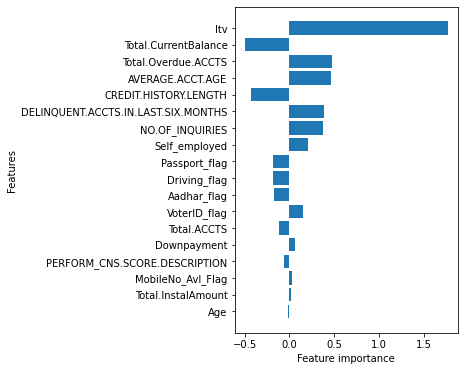

In [ ]:
sortLR= np.abs(importance).argsort()
plt.figure(figsize=(4,6))
plt.barh(X.columns[sortLR], importance[sortLR])
plt.xlabel('Feature importance')
plt.ylabel('Features')
#plt.savefig('LR_importance.png',dpi=150,bbox_inches='tight')

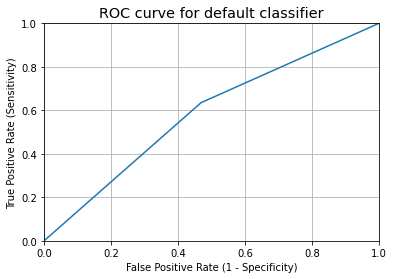

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_vali, y_vali_pred)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for default classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [ ]:
shap.initjs()# Need to load JS vis in the notebook

In [ ]:
X_train.columns

Index(['ltv', 'MobileNo_Avl_Flag', 'PERFORM_CNS.SCORE.DESCRIPTION',
       'VoterID_flag', 'NO.OF_INQUIRIES', 'Total.Overdue.ACCTS', 'Total.ACCTS',
       'Age', 'Self_employed', 'Total.CurrentBalance', 'Total.InstalAmount',
       'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'AVERAGE.ACCT.AGE',
       'CREDIT.HISTORY.LENGTH', 'Downpayment', 'Passport_flag', 'Aadhar_flag',
       'Driving_flag'],
      dtype='object')

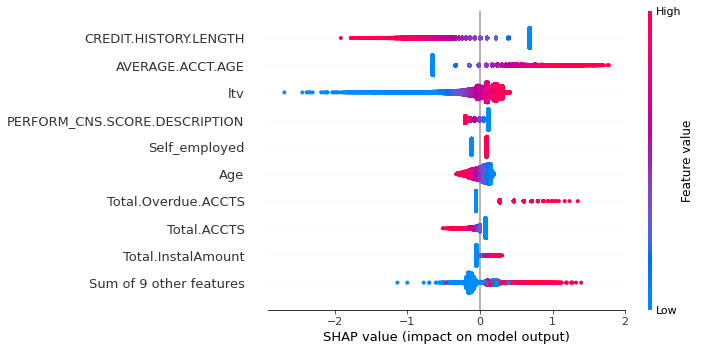

In [ ]:
explainer = shap.Explainer(lr, X_train, feature_names=X_train.columns)
shap_values = explainer(X_vali)
shap.plots.beeswarm(shap_values)

In [ ]:

glm_binom = sm.GLM(y_train, X_train, family=sm.families.Binomial())
res = glm_binom.fit()

# glm_binom = sm.Logit(y_train, X_train)
# res = glm_binom.fit()
print(res.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:           loan_default   No. Observations:                70852
Model:                            GLM   Df Residuals:                    70834
Model Family:                Binomial   Df Model:                           17
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -47524.
Date:                Thu, 03 Jun 2021   Deviance:                       95048.
Time:                        13:08:53   Pearson chi2:                 7.11e+04
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
lt

In [ ]:
# def deviance(X, y, model):
#     return 2*metrics.log_loss(y, model.predict_proba(X), normalize=False)

In [ ]:
# range_list = np.arange(0, len(X_train),1)
# deviance_list=[]
# for i in range_list:
#     deviance= deviance(X_train.iloc[i,:], y_train[i], lr)
#     deviance_list.append(deviance)

Text(0.5, 0, 'Fitted values')

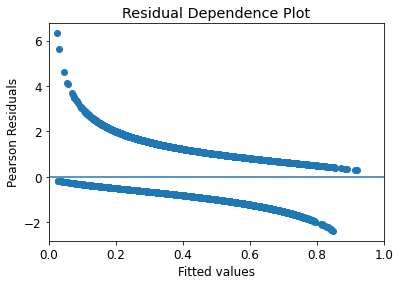

In [ ]:
yhat = res.mu
fig, ax = plt.subplots()

ax.scatter(yhat, res.resid_pearson)
ax.hlines(0, 0, 1)
ax.set_xlim(0, 1)
ax.set_title('Residual Dependence Plot')
ax.set_ylabel('Pearson Residuals')
ax.set_xlabel('Fitted values')

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


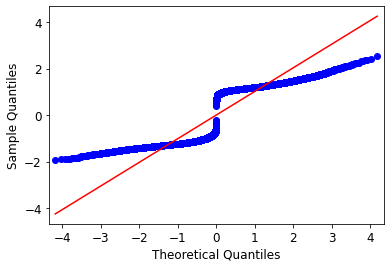

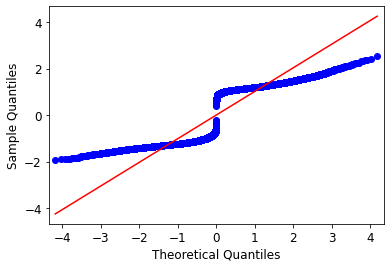

In [ ]:
resid = res.resid_deviance.copy()
graphics.gofplots.qqplot(resid, line='r')

Text(0, 0.5, 'Ordered Values')

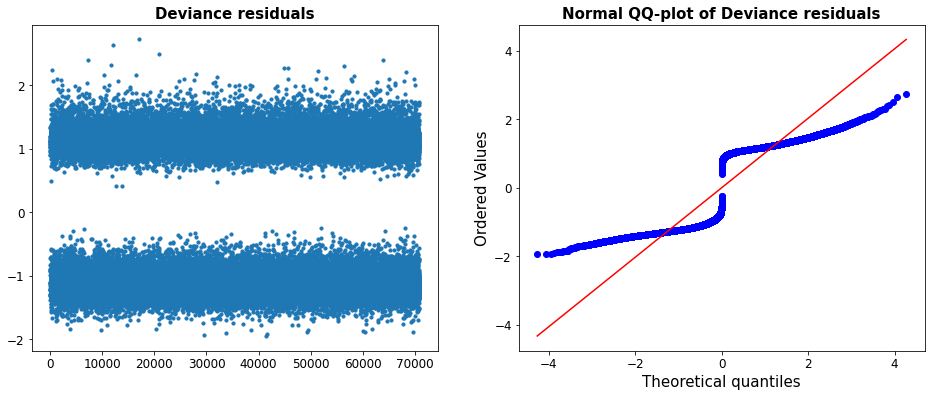

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(range(len(res.resid_deviance)),res.resid_deviance,s=10)
# plt.scatter(range(len(res.resid_dev)),res.resid_dev,s=10)
plt.title('Deviance residuals',size=15,weight="bold")
ax1 = fig.add_subplot()
plt.subplot(1,2,2)
scipy.stats.probplot(res.resid_deviance, dist=scipy.stats.norm, plot=pylab)
#scipy.stats.probplot(res.resid_dev, dist=scipy.stats.norm, plot=pylab)
#ax1.get_lines()[0].set_markeredgecolor ('#6495ED')
#ax1.get_lines()[0].set_markerfacecolor('#6495ED')
#ax1.get_lines()[1].set_color('#FF1493')
plt.title("Normal QQ-plot of Deviance residuals", weight="bold",size=15)
plt.xlabel('Theoretical quantiles',size=15)
plt.ylabel('Ordered Values',size=15)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=85463a1c-f246-4a97-953d-d1ccc73b61e9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>